Train: 76483, Val: 21852, Test: 10927


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50]
  Train -> Acc: 84.57% | Loss: 0.0770
  Val   -> Acc: 91.31% | Loss: 0.0402
  ✅ Best model saved (state_dict).
Epoch [2/50]
  Train -> Acc: 93.05% | Loss: 0.0296
  Val   -> Acc: 93.60% | Loss: 0.0239
  ✅ Best model saved (state_dict).
Epoch [3/50]
  Train -> Acc: 94.89% | Loss: 0.0204
  Val   -> Acc: 95.14% | Loss: 0.0185
  ✅ Best model saved (state_dict).
Epoch [4/50]
  Train -> Acc: 95.63% | Loss: 0.0165
  Val   -> Acc: 95.60% | Loss: 0.0156
  ✅ Best model saved (state_dict).
Epoch [5/50]
  Train -> Acc: 96.01% | Loss: 0.0143
  Val   -> Acc: 95.90% | Loss: 0.0139
  ✅ Best model saved (state_dict).
Epoch [6/50]
  Train -> Acc: 96.29% | Loss: 0.0129
  Val   -> Acc: 96.23% | Loss: 0.0128
  ✅ Best model saved (state_dict).
Epoch [7/50]
  Train -> Acc: 96.56% | Loss: 0.0119
  Val   -> Acc: 96.45% | Loss: 0.0119
  ✅ Best model saved (state_dict).
Epoch [8/50]
  Train -> Acc: 96.82% | Loss: 0.0110
  Val   -> Acc: 96.69% | Loss: 0.0111
  ✅ Best model saved (state_dict).
Epoch [9

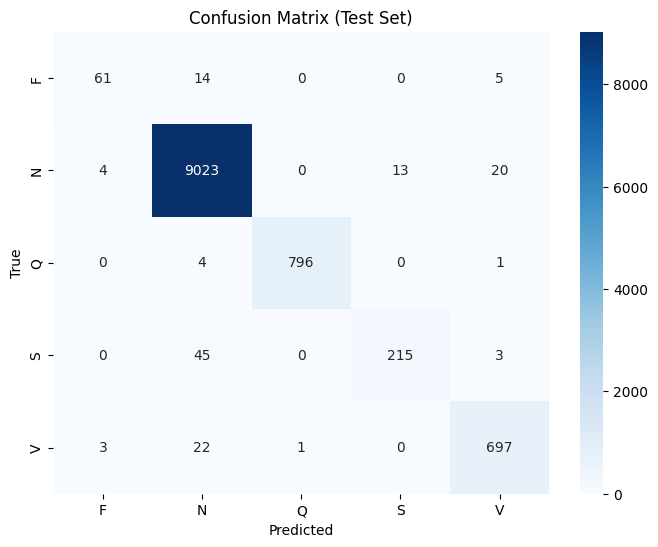

(KAN(
   (layers): ModuleList(
     (0-1): 2 x KANLinear(
       (base_activation): SiLU()
     )
   )
 ),
 {'train_acc': [84.57434985552345,
   93.04551338205876,
   94.88513787377588,
   95.63301648732399,
   96.00957075428526,
   96.29460141469346,
   96.56394231397827,
   96.81759345213969,
   96.95749382215656,
   97.1627681968542,
   97.29090124602853,
   97.45564373782409,
   97.58900670737287,
   97.66091811252174,
   97.78905116169607,
   97.88580468862362,
   98.01524521789156,
   98.07800426238511,
   98.21005975184028,
   98.24797667455513,
   98.35126760195077,
   98.41141168625708,
   98.47940065112509,
   98.5395447354314,
   98.5983813396441,
   98.60753370029941,
   98.68598250591634,
   98.73174430919289,
   98.79581083378005,
   98.81803799537153,
   98.83111279630768,
   98.8834120000523,
   98.9174064824863,
   98.94878600473308,
   98.97885804688623,
   99.01938992978832,
   99.02331237006916,
   99.08084149418825,
   99.09783873540525,
   99.1096060562478,
   99.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  7 16:23:09 2024

@author: liaihua
"""

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix


# 1. 数据加载与预处理
data = pd.read_csv('/kaggle/input/mit-bih-data/ECG_data.csv')

# 提取信号和标签
signals = data['Signal'].apply(lambda x: np.fromstring(x[1:-1], sep=',')).values
labels = data['Label'].values

# 转换信号为NumPy数组
signals = np.array([np.array(signal) for signal in signals])
# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
# 数据分割
X_train, X_temp, y_train, y_temp = train_test_split(
    signals, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded)

# 第二步：将临时集中的 2/3 设为验证集（20%），1/3 设为测试集（10%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# 检查划分比例
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 2. 转换输入格式
X_train = X_train.reshape(-1, 1, 300)
# 每个样本300个时间步，每个时间步一个特征 (channels=1, seq_len=300)
X_val = X_val.reshape(-1, 1, 300)
X_test = X_test.reshape(-1, 1, 300)


# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# 3. Focal Loss 定义
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 使用 softmax 计算每个类别的概率
        inputs = F.softmax(inputs, dim=1)
        
        # 创建 one-hot 编码的标签
        targets = F.one_hot(targets, num_classes=self.num_classes)
        
        # 计算 p_t
        p_t = torch.sum(inputs * targets, dim=1)
        
        # 计算 focal loss
        loss = -self.alpha * (1 - p_t) ** self.gamma * torch.log(p_t)
        
        # 根据 reduction 类型计算最终损失
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )
#定义 KAN 模型
model = KAN([300,128,64,32,5]) # 输入维度300，隐藏层，5个输出类别
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用 GPU 或 CPU
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)
# 定义损失函数
criterion = FocalLoss()  # 使用 Focal Loss

def specificity_score_weighted(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + np.diagonal(cm)
    fp = cm.sum(axis=0) - np.diagonal(cm)
    spec_per_class = tn / (tn + fp + 1e-6)
    class_support = cm.sum(axis=1)
    total = class_support.sum()
    return np.sum((class_support / total) * spec_per_class)
def compute_test_metrics(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    
    start_time = time.time()
    with torch.no_grad():
        for data, target in data_loader:
            data = data.view(-1, 300).to(device)
            target = target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    end_time = time.time()
    elapsed_time = end_time - start_time

    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    sensitivity = recall_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    tn = conf_matrix.sum() - conf_matrix.sum(axis=0) - conf_matrix.sum(axis=1) + np.diagonal(conf_matrix)
    fp = conf_matrix.sum(axis=0) - np.diagonal(conf_matrix)
    specificity_per_class = tn / (tn + fp + 1e-6)
    samples_per_class = conf_matrix.sum(axis=1)
    total_samples = np.sum(samples_per_class)
    specificity = np.sum((samples_per_class / total_samples) * specificity_per_class)


    return accuracy, f1, sensitivity, precision, specificity, conf_matrix, elapsed_time
def plot_acc_loss(history):
    epochs = range(1, len(history['train_acc']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color='tab:blue')
    ax1.plot(epochs, history['train_acc'], label='Train Accuracy', color='tab:blue', linestyle='-')
    ax1.plot(epochs, history['val_acc'], label='Val Accuracy', color='tab:blue', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(90,100)
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(epochs, history['train_loss'], label='Train Loss', color='tab:red', linestyle='-')
    ax2.plot(epochs, history['val_loss'], label='Val Loss', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0,0.03)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Accuracy and Loss over Epochs')
    fig.tight_layout()
    plt.savefig("KANs Accuracy_Loss Dual Axis.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler,num_epochs):
    history = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }
    best_val_loss = float('inf')  
    best_model_path = 'KANs best_model.pth'
    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            data = data.view(-1, 300).to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.view(-1, 300).to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train -> Acc: {train_acc:.2f}% | Loss: {train_loss:.4f}")
        print(f"  Val   -> Acc: {val_acc:.2f}% | Loss: {val_loss:.4f}")
   

        # === Save Best Model (based on validation loss) ===
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), best_model_path)
          print("  ✅ Best model saved (state_dict).")
        else:
          print("  No improvement.")
        # === Adjust Learning Rate Dynamically ===
        scheduler.step(val_loss)
        
    # === 重新加载最优模型进行测试 ===
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # === 测试集评估 ===
    test_acc, test_f1, test_sen, test_ppv, test_spe, conf_matrix, test_time = compute_test_metrics(model, test_loader)


    print("\n=== Final Test Set Performance ===")
    print(f"Test Acc: {test_acc:.2f}% | F1: {test_f1:.4f} | Sensitivity: {test_sen:.4f} | "
          f"PPV: {test_ppv:.4f} | Specificity: {test_spe:.4f}")
    print(f"🕒 Inference Time on Test Set: {test_time:.2f} seconds")


    # 混淆矩阵图
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.savefig("KANs Confusion Matrix.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return model, history

train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer,scheduler, num_epochs=50)
        
